In [1]:
import numpy as np
import cv2 as cv
from tqdm import tqdm
import mrob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from arucoprocessor import ArucoProcessor

In [2]:
cap = cv.VideoCapture('aruco_video.mp4')
# cap = cv.VideoCapture('table.mp4')

frameCount = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
ret = True

while (fc < frameCount  and ret):
    ret, buf[fc] = cap.read()
    fc += 1

cap.release()

In [7]:
# sift = cv.SIFT_create(nfeatures=1500)
orb = cv.ORB_create(nfeatures=500)

# bf = cv.BFMatcher()
bf = cv.BFMatcher(cv.NORM_HAMMING)
apc = ArucoProcessor()

# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks=50) # or pass empty dictionary
# flann = cv.FlannBasedMatcher(index_params,search_params)

keyframe_index = 0
frame_index = 0

keyframes = []
detected_arucos = []

initialization = True

for frame_index in tqdm(range(buf.shape[0])):
    
    frame = buf[frame_index]
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    if initialization:
        see_arucos = apc.process_frame(gray)
    if frame_index > 150 and initialization:
        initialization = False

    # kp, des = sift.detectAndCompute(gray,None)
    kp, des = orb.detectAndCompute(gray,None)

    if frame_index == 0:
        keyframe_kp = kp
        keyframe_des = des
        keyframe_img = gray
        keyframe_index = frame_index
        keyframes.append((keyframe_index, keyframe_kp, keyframe_img))

    if frame_index != 0:

        matches = bf.knnMatch(prev_des, des, k=2)
        keyframe_matches = bf.knnMatch(keyframe_des, des, k=2)

        # matches = flann.knnMatch(prev_des, des, k=2)
        # keyframe_matches = flann.knnMatch(keyframe_des, des, k=2)

        good = []
        for m,n in keyframe_matches:
            if m.distance < 0.7*n.distance:
                good.append(m)
                # good.append([m])

        # img=cv.drawKeypoints(gray, kp, None)
        # cv.imshow('frame', img)

        # cv.imshow('frame', cv.drawMatchesKnn(keyframe_img, keyframe_kp, gray, kp, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
        # if cv.waitKey(1) == ord('q'):
        #     break

        if initialization and see_arucos:
            if frame_index-keyframe_index > 15 or len(good) < 100:
                keyframe_kp = kp
                keyframe_des = des
                keyframe_index = frame_index
                keyframe_img = gray
                keyframes.append((keyframe_index, keyframe_kp, keyframe_img, good))
                detected_arucos.append((keyframe_index, apc.get_pose_wrt_aruco(), apc.get_corners()))
        else:
            if len(good) < 100:
                keyframe_kp = kp
                keyframe_des = des
                keyframe_index = frame_index
                keyframe_img = gray
                keyframes.append((keyframe_index, keyframe_kp, keyframe_img, good))

    prev_kp = kp
    prev_des = des
    prev_img = gray

cv.destroyAllWindows()

  1%|          | 4/496 [00:00<00:27, 17.87it/s]

Reliable


100%|██████████| 496/496 [00:22<00:00, 21.61it/s]


In [8]:
positions = []
for a in range(len(detected_arucos)):
    positions.append(detected_arucos[a][1][:3, 3])
positions = np.array(positions)

In [9]:
layout = go.Layout(
             scene=dict(
                 aspectmode='data'
         ))

fig = go.Figure(data=[go.Scatter3d(x=positions.T[0], y=positions.T[1], z=positions.T[2],
                                    marker_size=5, text=np.arange(0, len(positions)), line=dict(
        color='darkblue',
        width=2
    )
)], layout=layout)

fig.show()

In [10]:
len(keyframes)

27

In [11]:
global_matches = []

for m in range(len(keyframes[1][3])):
    global_matches.append([keyframes[1][3][m].queryIdx, keyframes[1][3][m].trainIdx])

for kf in tqdm(range(2, len(keyframes))):
    for m in range(len(keyframes[kf][3])):
        found_match = False
        for global_match in global_matches:
            if global_match[-1] == keyframes[kf][3][m].queryIdx and len(global_match) != kf+1:
                global_match.append(keyframes[kf][3][m].trainIdx)
                found_match = True
        if not found_match:
            global_matches.append([-1] * (kf - 1) + [keyframes[kf][3][m].queryIdx, keyframes[kf][3][m].trainIdx])
            
    for global_match in global_matches:
        if len(global_match) < kf + 1:
            global_match.extend([-1])

assert len(keyframes) == min([len(x) for x in global_matches]) == max([len(x) for x in global_matches])

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:01<00:00, 15.49it/s]


In [12]:
global_matches = np.array(global_matches)

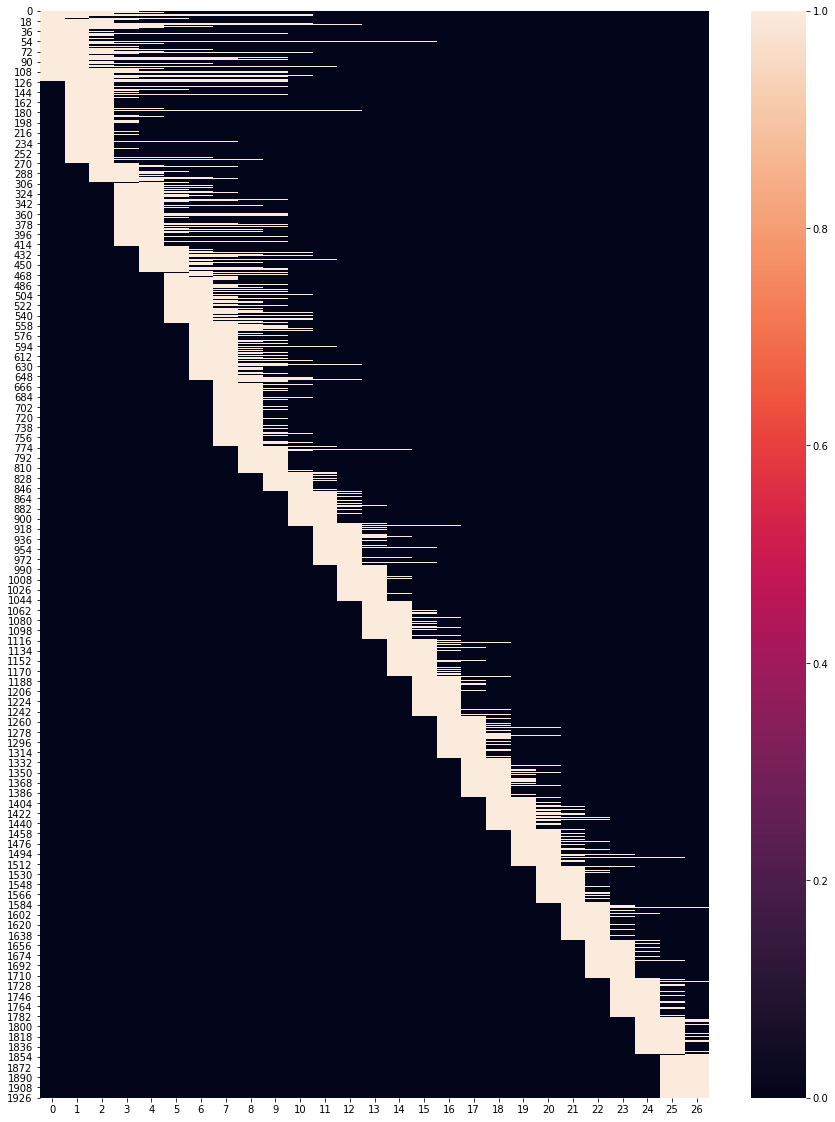

In [13]:
plt.figure(figsize=(15, 20))
sns.heatmap(np.where(global_matches > 0, 1, 0));

In [15]:
W = np.identity(2)

K = np.array([[1.23472227e+03, 0.00000000e+00, 6.38814655e+02],
              [0.00000000e+00, 1.23122213e+03, 3.37257425e+02],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

camera_k = np.array([K[0, 0],
                     K[1, 1],
                     K[0, 2],
                     K[1, 2]])

marker_size = 0.144

marker_points = np.array([[-marker_size / 2, -marker_size / 2, 0],
                          [ marker_size / 2, -marker_size / 2, 0],
                          [ marker_size / 2,  marker_size / 2, 0],
                          [-marker_size / 2,  marker_size / 2, 0]])

In [12]:
mrob.RANSAC?

Type:           FGraph.robustFactorType
String form:    FGraph.robustFactorType.RANSAC
File:           c:\users\almam\anaconda3\lib\site-packages\mrob\pybind.cp38-win_amd64.pyd
Docstring:     
Members:

QUADRATIC

CAUCHY

HUBER

MCCLURE

RANSAC
Init docstring: __init__(self: mrob.pybind.FGraph.robustFactorType, value: int) -> None


In [16]:
detected_arucos

[(16,
  array([[ 0.98963018, -0.01305672, -0.14304413, -0.01820462],
         [-0.00945727,  0.98777636, -0.15559054,  0.16952419],
         [ 0.14332712,  0.1553299 ,  0.97740982, -1.7388141 ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]]),
  array([[779., 360.],
         [883., 359.],
         [885., 462.],
         [780., 462.]], dtype=float32)),
 (32,
  array([[ 0.95798596, -0.0300613 , -0.28523536,  0.22096643],
         [ 0.01362753,  0.99813969, -0.05942597, -0.01905454],
         [ 0.28649115,  0.05304219,  0.95661348, -1.74002953],
         [ 0.        ,  0.        ,  0.        ,  1.        ]]),
  array([[792., 371.],
         [895., 369.],
         [898., 473.],
         [794., 473.]], dtype=float32)),
 (48,
  array([[ 0.99268965, -0.00484202, -0.12059773, -0.09151257],
         [-0.0047219 ,  0.99687195, -0.07889242, -0.13486337],
         [ 0.12060249,  0.07888514,  0.98956161, -1.80557465],
         [ 0.        ,  0.        ,  0.        ,  1.        ]]),


In [20]:
graph.add_factor_1pose_3d?

Docstring: add_factor_1pose_3d(self: mrob.pybind.FGraph, arg0: mrob.pybind.geometry.SE3, arg1: int, arg2: numpy.ndarray[numpy.float64[6, 6]]) -> int
Type:      method


In [62]:
mrob.CAUCHY?

Type:           FGraph.robustFactorType
String form:    FGraph.robustFactorType.CAUCHY
File:           c:\users\almam\anaconda3\lib\site-packages\mrob\pybind.cp38-win_amd64.pyd
Docstring:     
Members:

QUADRATIC

CAUCHY

HUBER

MCCLURE

RANSAC
Init docstring: __init__(self: mrob.pybind.FGraph.robustFactorType, value: int) -> None


In [68]:
graph = mrob.FGraph(mrob.CAUCHY)

global_matches_to_graph_id = {}
corners_to_graph_id = {}

poses_indeces_in_graph = []
last_position = np.zeros((3, 1))

for angle in range(4):
    l = graph.add_node_landmark_3d(marker_points[angle], mrob.NODE_ANCHOR)
    corners_to_graph_id[angle] = l

for kf in tqdm(range(len(keyframes))):
# for kf in tqdm(range(len(detected_arucos))):

    if len(detected_arucos) > kf:
        pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]))

        for angles in range(4):
            graph.add_factor_camera_proj_3d_point(
                obs = detected_arucos[kf][2][angle],
                nodePoseId = pose_id,
                nodeLandmarkId = corners_to_graph_id[angle],
                camera_k = camera_k,
                obsInvCov = W)

    # if kf == 0:
    #     pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(), mrob.NODE_ANCHOR)
    else:
        pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(last_pose))
        # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

    poses_indeces_in_graph.append(pose_id)
    
    for global_match_index in range(global_matches.shape[0]):

        if global_matches[global_match_index, kf] == -1:
            continue
        
        if not (global_match_index in global_matches_to_graph_id.keys()):
            l = graph.add_node_landmark_3d(last_position + np.random.random((3, 1)))
            # l = graph.add_node_landmark_3d(np.random.random((3, 1)))
            global_matches_to_graph_id[global_match_index] = l
            
        graph.add_factor_camera_proj_3d_point(
                obs = keyframes[kf][1][global_matches[global_match_index, kf]].pt,
                nodePoseId = pose_id,
                nodeLandmarkId = global_matches_to_graph_id[global_match_index],
                camera_k = camera_k,
                obsInvCov = W)
    
    # print(f"{kf} : {graph.solve(method=mrob.LM, maxIters=200)} iterations")
    graph.solve(method=mrob.LM)
    last_pose = graph.get_estimated_state()[pose_id]
    last_position = last_pose[0:3, 3:]
    
print(graph.chi2())

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:10<00:00,  2.52it/s]

3152269196.246515


In [69]:
landmarks_3d = np.array([x for x in np.array(graph.get_estimated_state())[list(global_matches_to_graph_id.values())]]).reshape(-1, 3).T
camera_poses = np.array([x[0:3, 3] for x in np.array(graph.get_estimated_state())[poses_indeces_in_graph]]).T

<ipython-input-69-1089bd6a750f>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

<ipython-input-69-1089bd6a750f>:2: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [70]:
fig = go.Figure(data=[go.Scatter3d(x=landmarks_3d[0], y=landmarks_3d[1], z=landmarks_3d[2],
                                   mode='markers', marker_size=1)] + 
                     [go.Scatter3d(x=marker_points.T[0], y=marker_points.T[1], z=marker_points.T[2],
                                   mode='markers', marker_size=3)] + 
                     [go.Scatter3d(x=camera_poses[0], y=camera_poses[1], z=camera_poses[2],
                                   mode='markers', marker_size=5, text=np.arange(0, len(keyframes)))])

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[np.min(camera_poses, axis=1)[0]*2, np.max(camera_poses, axis=1)[0]*2]),
        yaxis = dict(nticks=4, range=[np.min(camera_poses, axis=1)[1]*2, np.max(camera_poses, axis=1)[1]*2]),
        zaxis = dict(nticks=4, range=[np.min(camera_poses, axis=1)[2]*2, np.max(camera_poses, axis=1)[2]*2]),
        aspectmode='data'))

fig.show()
# fig.write_html("feature_map.html")

In [57]:
# U, S, V = np.linalg.svd(camera_poses)
# S[2] = 0
# projected_points = U[:2, :] @ np.diag(S[:]) @ V.T[:3, :]

# plt.figure(figsize=(15, 10))
# plt.scatter(projected_points[0], projected_points[1], )
# plt.plot(projected_points[0], projected_points[1])
# for i in range(projected_points.shape[1]):
#     plt.annotate(i, (projected_points[0][i], projected_points[1][i]))
# plt.show()

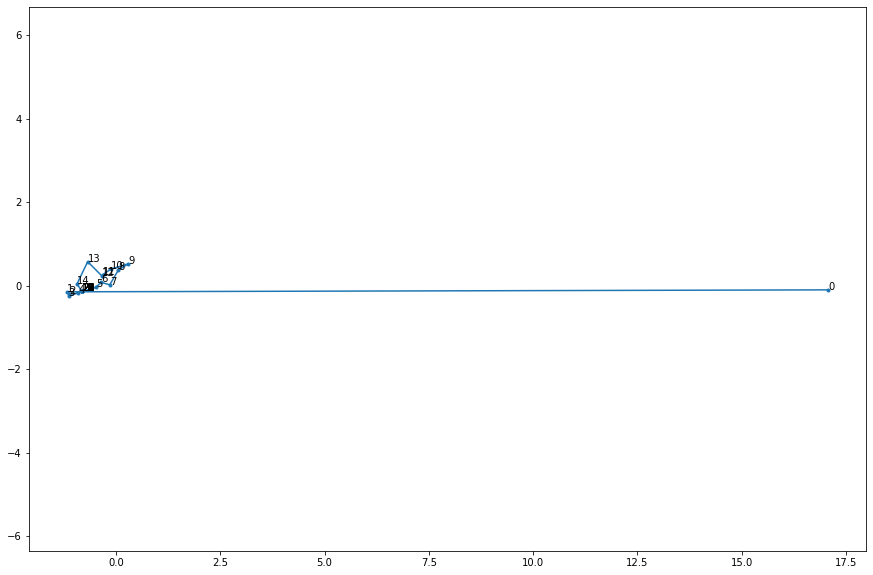

In [71]:
pca = PCA(n_components=2)
proj_points = pca.fit_transform(camera_poses.T)
proj_points = proj_points.T

plt.figure(figsize=(15, 10))
plt.axis('equal')
plt.plot(proj_points[0], proj_points[1], marker='.')
for i in range(proj_points.shape[1]):
    plt.annotate(i, (proj_points[0][i], proj_points[1][i]))
plt.show()

In [ ]:
# global_matches = []

# for m in range(len(keyframes[1][3])):
#     global_matches.append([keyframes[1][3][m].queryIdx, keyframes[1][3][m].trainIdx])

# for kf in tqdm(range(2, len(keyframes))):
#     for m in range(len(keyframes[kf][3])):
#         found_match = False
#         for global_match in global_matches:
#             if global_match[-1] == keyframes[kf][3][m].queryIdx and len(global_match) != kf+1:
#                 global_match.append(keyframes[kf][3][m].trainIdx)
#                 found_match = True
#         if not found_match:
#             global_matches.append([-1] * (kf - 1) + [keyframes[kf][3][m].queryIdx, keyframes[kf][3][m].trainIdx])
            
#     for global_match in global_matches:
#         if len(global_match) < kf + 1:
#             global_match.extend([-1])

# assert len(keyframes) == min([len(x) for x in global_matches]) == max([len(x) for x in global_matches])

# global_matches = []

# for kf_1 in tqdm(range(len(keyframes))):
    
#     kp_1, des_1 = orb.detectAndCompute(keyframes[kf_1][2], None)

#     for kf_2 in range(kf_1 + 1, len(keyframes)):
#         kp_2, des_2 = orb.detectAndCompute(keyframes[kf_2][2], None)
#         matches = bf.knnMatch(des_1, des_2, k=2)

#         for m,n in keyframe_matches:
#             if m.distance < 0.75*n.distance:
#                 good.append(m)
            
#         for m in good:
